# League of Legends Match Analytics
## Introduction

League of Legends is a competitive video game owned by Riot Games in which 10 players compete against each other in teams of 5. It is one of the most played and viewed video games in the world. Since 2011, Riot Games has hosted professional "leagues" in various regions around the world. The best teams from each region come to the Wold Championship where the best team wins the Summoner's Cup. Since its inception, the World Championship has been dominated by the Korean teams. This is an attempt to apply data driven methods to find latent variables that can explain the Korean dominance in professional League of Legends matches. All of the data has been kindly provided by [Tim Sevenhuysen](https://twitter.com/TimSevenhuysen) on his website: [Oracle's Elixir](https://oracleselixir.com/).

## Exploratory analysis

To make the analysis easier, I'm doing to import a bunch of packages and define some methods first

In [336]:
import sys
sys.path.append(".//utils//")
import sqlite3, os
import pandas as pd
import parsing_utils
from parsing_utils import parse_databases
import importlib
importlib.reload(parsing_utils)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display_html

def display_side_by_side(series, names, feature):
    srs = []
    n=0
    for ii in series:
        ii = pd.DataFrame(ii.rename_axis(names[n],axis=0).rename(feature))
        ii[names[n]] = ii.index
        ii = ii.reset_index(drop=True)
        ii.index = np.arange(1, len(ii) + 1)
        srs.append(ii.loc[:,[names[n],feature]])
        n+=1
    final_table = pd.concat(srs,axis=1)
    #display(final_table)
    return final_table

def get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins):
    all_matches = {}
    all_teams = {}
    parser = parse_databases()
    for ii, jj in zip(aliases,leagues):
        alias = ii
        league = jj
        name = "{}_{}_{}_{}s".format(year,alias,season,focus)
        matches,teams  = parser.parse_tables_get_matches(db_dir,alias,joins,anti_joins,name,year,league)
        try:
            name = matches["league"].value_counts().index.values[0]
            all_matches[name] = matches
            all_teams[name] = teams
            #print(matches["league"].value_counts())
        except:
            print("League {} does not have any data for {}".format(jj,season))
    return all_matches, all_teams

def get_fig_axes(n=1,m=2,w=10,h=5,sharey=False):
    fig,ax = plt.subplots(n,m,figsize=(w,h),sharey=sharey)
    axes = ax.flatten()
    return fig,axes
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
query = "select * from 'sqlite_master' where type = 'table';"
#cursor = match.cursor()
#cur_exec = cursor.execute(query)
print(pd.read_sql_query(query,match))

     type                       name                   tbl_name  rootpage  \
0   table          2016matchdata.txt          2016matchdata.txt         2   
1   table          2017matchdata.txt          2017matchdata.txt      3444   
2   table          2018matchdata.txt          2018matchdata.txt      8429   
3   table              2016matchdata              2016matchdata     10266   
4   table              2017matchdata              2017matchdata     13709   
5   table              2018matchdata              2018matchdata     18693   
6   table   2016_na_playoffs_players   2016_na_playoffs_players     20555   
7   table  2016_lck_playoffs_players  2016_lck_playoffs_players     20557   
8   table   2016_eu_playoffs_players   2016_eu_playoffs_players     20559   
9   table  2016_lms_playoffs_players  2016_lms_playoffs_players     20561   
10  table   2017_na_playoffs_players   2017_na_playoffs_players     20563   
11  table  2017_lck_playoffs_players  2017_lck_playoffs_players     20565   

Now, if we look at the top 5 teams from the World Championships since 2014, we can see that Korean and Chinese teams usually dominate the field:

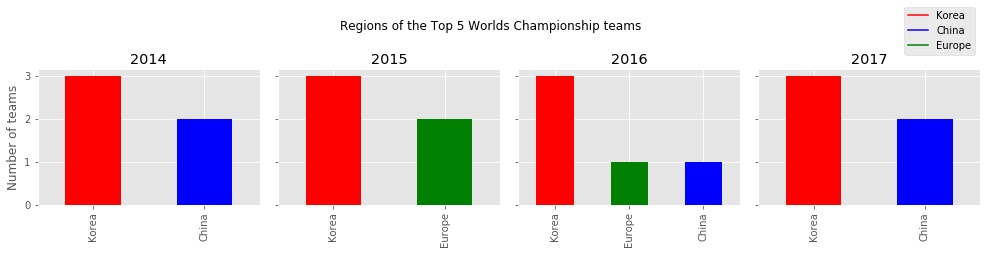

In [337]:
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
regions = {'2014':['Korea','Korea','Korea','China','China'],'2015':['Korea','Korea','Europe','Europe','Korea'],
          '2016':['Korea','Korea','Korea','Europe','China'],'2017':['Korea','Korea','China','China','Korea']}
fig,ax = plt.subplots(1,4,figsize=(14,3), sharey=True)
axes = ax.flatten()
colors = {'Korea':'r','China':'b','Europe':'g'}
n=0
axes[0].set_ylabel("Number of teams")
for ii in ['2014','2015','2016','2017']:
    query="""SELECT name FROM international.'sqlite_master' WHERE type = 'table' 
    AND name LIKE '%championships%' AND name LIKE '%team%' AND name LIKE '%{}%';""".format(ii)
    table = pd.read_sql_query(query,match).iloc[0,0]
    query="""SELECT * FROM international.'{}' ORDER BY W DESC, L ASC;""".format(table)
    top5 = pd.read_sql_query(query,match).head(5)
    top5["Region"] = regions[ii]
    cols = [colors[ii] for ii in top5["Region"].value_counts().index.values]
    top5["Region"].value_counts().plot.bar(ax = axes[n], color = [cols])
    axes[n].set_title("{}".format(ii))
    n+=1
plt.suptitle("Regions of the Top 5 Worlds Championship teams",y=1.1)
legend = [plt.Line2D([0],[0],color='r',label='Korea'),plt.Line2D([0],[0],color='b',label='China')
          ,plt.Line2D([0],[0],color='g',label='Europe')]
plt.legend(handles=legend, loc='upper right',bbox_to_anchor=(1, 1.5))
plt.tight_layout()
plt.show()

European teams have made it into the top 5 in 2015 and 2016 but Korean teams have been 3 out of the top 5 teams consistently. Since 2013, Korean teams have also won the World Championship. There has been much speculation about the Korean dominance in the professional League of Legends circuit. In particular, many people have wondered why North America never seems to make it into the top 5 despite having the largest recruiting pool and the most enthusiastic fan base. I will try to answer the question by analyzing matches from the LCK (Korean circuit) and NA (North American circuit). Specifically, I will be comparing LCK with NA matches. I unfortunately only have complete match data for the 2016 and 2017 seasons so I will be limited to the last couple of years. I will start with 2017 first since it is more recent and is not too different in terms of gameplay changes to 2018. Lets see what we can find! 
### Choosing teams
In order to make a fair comparison between the two regions, I have to pick teams that I believe best represent these regions. I decided to use teams that made it to the Spring or Summer season playoffs in the respective years. If a team made it to either of the playoffs that year, that means they must have been better than at least half the teams in their region in that season since only half the teams that compete in a region move to the playoffs. Thus, I will be comparing the top 50% of Korean teams with the top 50% of North American teams in that same year. First let's get the 2017 matches for playoff teams in LCK and NA. I have custom scripts that parse my databases and give me the matches I want. The specific implementation can be found in `parsing_utils.py`. 
### Match team statistics

First, lets look at the overall team stats for each match. This will give us team wide stats for each match rather than each player's stats:

In [338]:
year = "2017"
focus = "team"
season = "playoffs"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
aliases = ["na","lck"]
leagues = ["NALCS","LCK"]
all_matches,all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)
na = all_matches["NALCS"]
lck = all_matches["LCK"]

The teams that made it to any of the NA playoffs in 2017 played a total of 782 matches together whereas the LCK teams played 606 matches. The reason for this discrepancy becomes clear when we look at the number of teams:

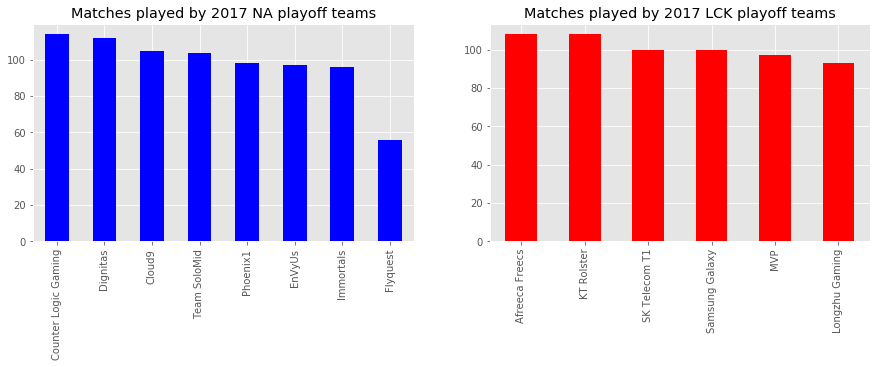

In [339]:
fig,axes = get_fig_axes(1,2,15,4)
na["team"].value_counts().plot.bar(ax=axes[0],color='b')
axes[0].set_title("Matches played by 2017 NA playoff teams")
lck["team"].value_counts().plot.bar(ax=axes[1],color='r')
axes[1].set_title("Matches played by 2017 LCK playoff teams")
plt.show()

There were only 6 teams from the LCK that made it to either the Spring or Summer playoffs compared with the 8 teams from NA. This seems to suggest that the matches in NA are more competitive than the matches in LCK. We can examine this more closely by looking at the ["GSPD"](https://oracleselixir.com/tag/gspd/) (Gold Spent Percentage Difference) statistic. "GSPD" measures if a match was a close one or if one team dominated. It measures the difference how much gold the winning team spent verses the losing team. If the difference is large, then it means the winning team had a large lead. If it is small or negative, then the losing team was keeping up in gold with the winning team. Lets compare the "GSPD" for NA vs LCK:

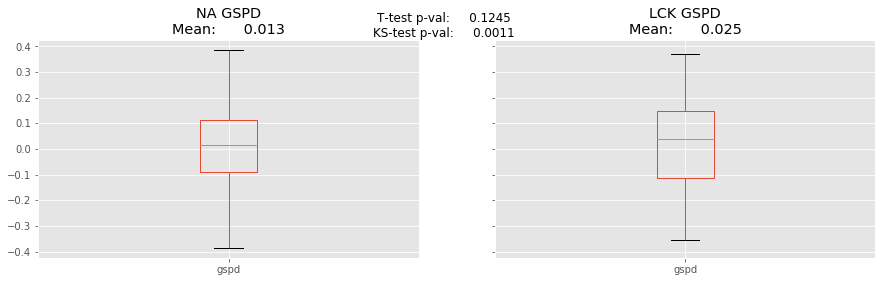

In [340]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
T_stat,p_val = ttest_ind(na["gspd"].values,lck["gspd"].values)
K_stat,p_val_k = ks_2samp(na["gspd"].values,lck["gspd"].values)
fig,axes = get_fig_axes(1,2,15,4,sharey=True)
na.boxplot('gspd',ax=axes[0])
axes[0].set_title("NA GSPD\nMean: {:10.3f}".format(na["gspd"].mean()))
lck.boxplot('gspd',ax=axes[1])
axes[1].set_title("LCK GSPD\nMean: {:10.3f}".format(lck["gspd"].mean()))
plt.suptitle("T-test p-val: {:10.4f}\nKS-test p-val: {:10.4f}".format(p_val,p_val_k))
plt.show()

Looking at the means and distributions, LCK in general had a higher GSPD than NA. I performed a KS test to measure if the two distributions were significantly different and a T-test for equality of the means. Although the T-test p-value is too high to say the two means are different, we can confidently say that the two distributions are different. We can be a littme more discriminant in our analysis. Lets rank the teams in the respective regions by their win rate and check their average gspd for the whole year:

In [341]:
s1 = na.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
#s1 = s1.rename_axis("NA Teams",axis=0).rename("2017 avg GSPD")
s2 = lck.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
#s2 = s2.rename_axis("LCK Teams",axis=0).rename("2017 avg GSPD")
names = ["NA Teams","LCK Teams"]
feature = "2017 avg GSPD"
series=[s1,s2]
table = display_side_by_side(series,names,feature)

This gives a clearer picture about what's going on. The top 3 NA teams tend to have a higher GSPD than the rest of the NA teams that qualified for playoffs whereas the LCK playoff teams tend to have a high GSPD in general. Again, this supports the notion that NA is more competitive than the LCK; the LCK teams that make it to the playoffs tend to dominate the field (according to the GSPD) whereas the NA teams tend to be more of a mixed bag. That seems interesting. Lets see if we can find a better explanation for why this is. To evaluate which features contribute to the differences between NA and LCK, I will train several models (Logistic Regression, Adaboost with Decision Trees, and Random Forest) and perform an anova to distinguish between matches in NA and LCK. Then I will see which features are the most important in distinguishing between the two groups.  

I will first clean the data for missing values by substituting the mean for some numerical columns, specific values for others, and the mode for categorical variables (this happens in the method `format_table()` in `analytics_utils.py`). I will then one hot encode categorical variables and standard scale the entire dataset.  

The training and testing are part of the `supervised_analysis` class from `analytics_utils.py`. I split the data in testing and training sets. The testing set will be used for 10 fold cross validation and the testing set will be used to calculate the area under the receiving operating characteristic (AUC). Then I extract the top 10 ranked features (for Adaboost, and RandomForest) or the features that had the largest coefficients (for Logistic Regression) and examine them. The coeficients for Logistic Regression normally aren't easy to interpret since different features can have different scales. However, since my features will be normalized to 0, I'm hoping that I can just use the coeficients for each feature to determine their importance to the classificaiton

In [342]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

leagues = ["NALCS","LCK"]
variable = "league"
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split"]
matches,data, y, colnames = get_final_table(leagues,variable,to_drop, all_matches)
sup = supervised_analysis(data,y,colnames)
log_comp,log_auc = sup.fit("Logit")
ada_comp,ada_auc = sup.fit("Adaboost")
tree_comp,tree_auc = sup.fit("Random Forest")
anova_comp = sup.anova()
print("Logit auc:{:10.4f}\nAdaboost auc: {:10.4f}\nRandom Forest auc:{:10.4f}\n".format(log_auc,ada_auc,tree_auc))

Logit auc:    0.7478
Adaboost auc:     0.7592
Random Forest auc:    0.6763



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  2   3   4 391 392 393 394 395 396 440] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


It seems that Logistic Regression and Adaboost perform quite well at classifying the matches in the correct league compared to Random Forest but all of them do better than random (largest class is 56%). Now lets look at the top 10 features for each algorithm as well as the ANOVA test between NA and LCK:

In [343]:
num_feats = all_matches["LCK"].loc[:,all_matches["LCK"].dtypes != np.dtype('O')].shape[1]
print("Total # of features: {}".format(matches.shape[1]))
print("Total # of numerical features: {}".format(num_feats))
algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST", "ANOVA"]
series=[log_comp[:10],ada_comp[:10],tree_comp[:10],anova_comp[:10]]
table = display_side_by_side(series,algs,"Importance")

Total # of features: 486
Total # of numerical features: 67


There are 486 features total (most of these are one hot encoded categorical features...). We see some of the same features appearing in all lists: `cspm`, `wcpm`, and `wpm` show up in all 4 lists. In general however, the features that show up in these lists are related to: gold generation (`cspm`, `earnedgpm`, `csat10`, `monsterkills`, `csat15`, `oppgoldat15`, `cspd`), vision control (`wpm`, `wcpm`, `visionwardbuys`, `wardkills`, `invisiblewardclearrate`), objective control (`fttime`, `oppbaronkills`), action with enemy champions (`dmgtochampsperminute`, `ckpm`, `teamdeaths`), and team composition (`ban1_Rengar`, `ban1_Cassiopeia`, `ban3_Elise`). It's interesting that Logistic Regression is the only one to rank features realted to team compositions. It's also interesting that GSPD also shows up as a predictive feature in Adaboost. 

Lets plot and do a T-Test for the features that intersect in all lists except ANOVA.

In [344]:
comps = []
complist = [log_comp,tree_comp,ada_comp]
for ii in complist:
    comps.append(ii.index.values[:10].tolist())
    
overlap = list(set(comps[0]).intersection(*comps))
print(overlap)


['wpm', 'wcpm', 'cspm', 'visionwardbuys']


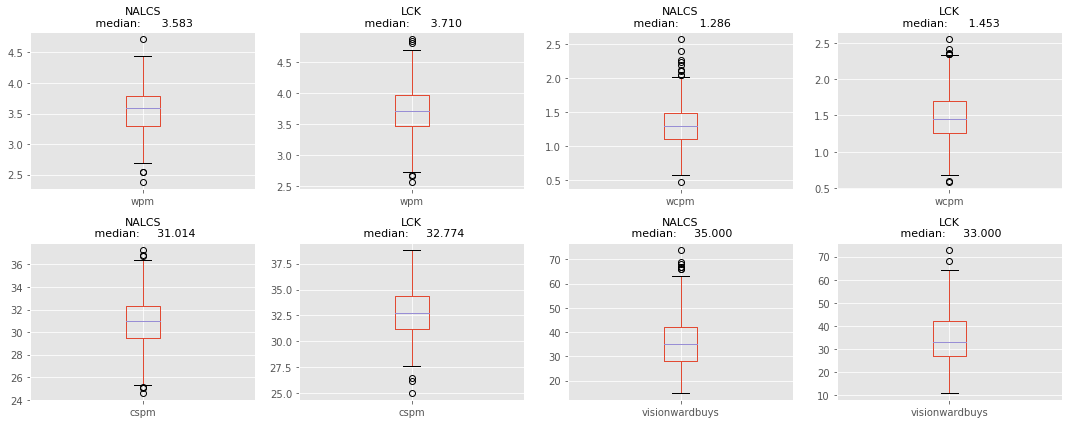

In [345]:
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

n=0
fig,axes = get_fig_axes(2,4,15,6,sharey=False)
for ii in overlap:
    if matches[ii].value_counts().index.shape[0] == 2:
        makeplot(matches,y,ii,"bar",[axes[n],axes[n+1]])
    else:
        makeplot(matches,y,ii,"notbar",[axes[n],axes[n+1]])
    n+=2
plt.tight_layout()
plt.show()

The boxplots seem normally distributed and my sample size is large (hundreds for each NA and LCK) so I feel that a T-Test would be appropriate in this case. There is a difference in these 4 features between NA and LCK teams but it's pretty small. LCK teams have slightly higher `cspm`, which is a measure of how much minions teams kill per minute (and thus a measure of gold generation), `wpm` and `wcpm`, which are measure of how many wards (which grant vision) teams put and clear respectively while NA teams have higher `visionwardbuys` which measures how many vision wards teams buy. This seems to suggest that LCK teams are slightly better at constant gold generation and vision control. It's intersting that NA teams have higher vision ward buys but don't seem to invest in invisible wards which are less likely to be cleared by the enemy team.   

It's interesting that all these differences are actually pretty small but consitent and statistically significant. It seems like the largest differences between NA and LCK come from vision control and gold generation although there might also be other differences in team compositions, fighting (team fights, dueling, kills, deaths...etc), and objective control.

### Examining differences in gold generation, vision control, objective control, team comp, and fighting

I'm going to dive deeper into some of these latent variables and examine player stats and see how they differ between NA and LCK. I will classify different subsets of features into these latent variables based on my knowledge of the game. Not all features will be contained in these sets. 


In [348]:
#new
gold_gen = ["earnedgoldshare","earnedgpm","gspd","goldspent","minionkills","monsterkills",
           "monsterkillsownjungle","monsterkillsenemyjungle","cspm","goldat10","oppgoldat10","gdat10",
           "goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10","csat15","oppcsat15","csdat15",
           "xpat10","oppxpat10","xpdat10"]
vision = ["wards","wpm","wardshare","wardkills","wcpm","visionwards","visionwardbuys","visiblewardclearrate",
         "invisiblewardclearrate"]
obj_ctr_vs = ["teamdragkills","elementals","firedrakes","waterdrakes","earthdrakes",
          "airdrakes","elders","herald","heraldtime","ft","fttime","firstmidouter",
          "teambaronkills","firsttothreetowers","fbaron","fbarontime"]
action_vs = ["k","d","a","teamkills","doubles","triples","quadras","pentas","fb","fbassist","fbvictim",
             "kpm","fbtime","fd","fdtime","dmgtochamps","dmgtochampsperminute","dmgshare","gamelength"]
team_comp = ["champion","ban1","ban2","ban3","ban4","ban5","position"]
biased = ["okpm","ckpm","opptowerkills","totalgold","oppelders","oppdragkills","oppelementals",
          "oppbaronkills","teamdeaths","teamtowerkills"]

In [349]:
#old
gold_gen = ["earnedgoldshare","totalgold","earnedgpm","goldspent","gspd","minionkills","monsterkills",
           "monsterkillsownjungle","monsterkillsenemyjungle","cspm","goldat10","oppgoldat10","gdat10",
           "goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10","csat15","oppcsat15","csdat15",
           "xpat10","oppxpat10","xpdat10"]
vision = ["wards","wpm","wardshare","wardkills","wcpm","visionwards","visionwardbuys","visiblewardclearrate",
         "invisiblewardclearrate"]
obj_ctr = ["teamdragkills","oppdragkills","elementals","oppelementals","firedrakes","waterdrakes","earthdrakes",
          "airdrakes","elders","oppelders","herald","heraldtime","ft","fttime","firstmidouter","teamtowerkills",
          "firsttothreetowers","opptowerkills","fbaron","fbarontime","teambaronkills","oppbaronkills"]
action = ["k","d","a","teamkills","teamdeaths","doubles","triples","quadras","pentas","fb","fbassist","fbvictim",
         "fbtime","kpm","okpm","ckpm","fd","fdtime","dmgtochamps","dmgtochampsperminute","dmgshare","gamelength"]
team_comp = ["champion","ban1","ban2","ban3","ban4","ban5","position"]
early_game = ["goldat10","oppgoldat10","gdat10","goldat15","oppgoldat15","gdat15","csat10","oppcsat10","csdat10",
              "csat15","oppcsat15","csdat15","xpat10","oppxpat10","xpdat10"]
obj_ctr_test = ["teamdragkills","oppdragkills","heraldtime","fttime","teamtowerkills","fbaron","fbarontime"]

In [350]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import analytics_utils
from analytics_utils import *
import importlib
importlib.reload(analytics_utils)

def get_subset_data(all_player_stats,var,role, variable):
    leagues = []
    player_stats = {}
    for ii in all_player_stats.keys():
        leagues.append(ii)
        s = all_player_stats[ii]
        #print(s.columns.values)
        player_stats[ii] = s.loc[s["position"].str.contains(role),:]
        player_stats[ii] = player_stats[ii].loc[:,var].dropna(axis=1,how="all")
    #print("#NA samples: {}\t#LCK samples: {}".format(na_players.shape[0],lck_players.shape[0]))
    to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split","player"]
    return get_final_table(leagues,variable,to_drop, player_stats)

def run_subset_analysis(data,y,colnames,matches):
    sup = supervised_analysis(data,y,colnames)
    log_comp, log_auc = sup.fit("Logit")
    ada_comp, ada_auc = sup.fit("Adaboost")
    tree_comp, tree_auc = sup.fit("Random Forest")
    anova_comp = sup.anova()
    auc_dict = {log_auc:log_comp,ada_auc:ada_comp,tree_auc:tree_comp}
    aucs=[log_auc,ada_auc,tree_auc]
    max_comp = max(aucs)
    algs = ["LOGSITIC REGRESSION","ADABOOST","RANDOM FOREST"]#, "ANOVA"]
    aucs = dict(zip(aucs,algs[:3]))
    print("Best Performing Algorithm is {} with an auc of: {:10.4f}\n".format(aucs[max_comp],max_comp))
    srs = []
    n=0
    for ii in [anova_comp[:10],ada_comp[:10],tree_comp[:10]]:#,anova_comp[:10]]:
        ii = ii.rename_axis(algs[n],axis=0).rename("Importance")
        n+=1
        srs.append(ii)
    table = display_side_by_side(srs,algs,"Importance")
    n=0
    fig,axes = get_fig_axes(2,4,20,7)
    for ii in auc_dict[max_comp].index.values[:4]:
        if matches[ii].value_counts().index.shape[0] == 2:
            makeplot(matches,y,ii,"bar",[axes[n],axes[n+1]])
        else:
            makeplot(matches,y,ii,"notbar",[axes[n],axes[n+1]])
        n+=2
    plt.tight_layout()
    plt.show()
    return table

def vs_matches_for_year_team(region, year, teams):
    other_teams = []
    region_teams = []
    for ii in teams.keys():
        if ii != region:
            for jj in teams[ii]["Team"].values:
                other_teams.append(jj)
    for ii in teams[region]["Team"].values:
        region_teams.append(ii)
    query = """SELECT * FROM '{}matchdata';""".format(year)
    matches = pd.read_sql_query(query,match)
    region_matches = matches.loc[matches["team"].isin(region_teams)]
    other_matches = matches.loc[matches["team"].isin(other_teams)]
    select_matches = other_matches.append(region_matches)
    region_gameids = region_matches["gameid"].unique()
    other_gameids = other_matches["gameid"].unique()
    region_vs_other = region_matches[region_matches["gameid"].isin(other_gameids)]
    other_vs_region = other_matches[other_matches["gameid"].isin(region_gameids)]
    print("Number of matches: {}".format(other_vs_region.shape[0]))
    try:
        region_vs_other.is_copy = False
        other_vs_region.is_copy = False
        region_vs_other["compare"] = region
        other_vs_region["compare"] = "NOT_"+region
    except:
        print("No matches between {} and other non-{} teams".format(region,region))
        return None
    if other_vs_region.shape[0] == 0:
        return None
    return {region:region_vs_other,"NOT_"+region: other_vs_region}

def unsupervised_analysis(data,y,colnames):
    pca = PCA()
    pca_transform = pca.fit(data).transform(data)
    good_data = pd.DataFrame(data,columns=colnames)
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    df = pd.concat([variance_ratios, components],axis=1)
    print("\nContributions to PCA component 1:")
    df2 = df[df.iloc[0,:].abs().sort_values(ascending=False).index]
    display(df2.head())
    #display(df.iloc[1,:].abs().sort_values(ascending=False).head())
    target_names = pd.unique(y)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)#, projection='3d')
    all_colors = ['blue', 'red','green','brown','yellow','cyan','black']
    colors = all_colors[:target_names.shape[0]]
    lw = 1

    for color, i in zip(colors, target_names):
        ax.scatter(pca_transform[y == i, 0], pca_transform[y == i, 1], 
                   color=color, alpha=.3, lw=lw, label=i)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA plot')
    plt.tight_layout()
    plt.show()
    #pd.plotting.scatter_matrix(good_data,figsize=(10,10), diagonal='kde')
    #plt.tight_layout()
    #plt.show()

In [351]:
def return_matches(matches,league, wc_teams, team):
    matches = matches[(matches["team"].isin(wc_teams))&(matches["league"] == league)]
    if team:
        matches = matches[matches["position"]=="Team"]
    else:
        matches = matches[matches["position"]!="Team"]
    matches["compare"] = matches["league"]
    return matches

def get_matches(year,team=True):
    parser = parse_databases()
    db_dir =  ".//databases"
    match,random = parser.get_dbs(db_dir)
    query = """SELECT * FROM '{}matchdata';""".format(year)
    matches = pd.read_sql_query(query,match)
    split = "{}-W".format(year)
    wc_teams = matches[matches["split"]==split]["team"].value_counts().index.values
    na_matches = return_matches(matches,"NALCS", wc_teams, team)
    lck_matches = return_matches(matches,"LCK", wc_teams, team)
    eu_matches = return_matches(matches,"EULCS", wc_teams, team)
    LMS_matches = return_matches(matches,"LMS", wc_teams, team)
    TCL_matches = return_matches(matches,"TCL", wc_teams, team)
    CB_matches = return_matches(matches,"CBLoL", wc_teams, team)
    all_matches = {"NA":na_matches,"EU":eu_matches,"LCK":lck_matches,"LMS":LMS_matches,"TCL":TCL_matches, "CB":CB_matches}
    return all_matches

YEAR: 2016

RUNNING ANALYSIS FOR gold_gen



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is RANDOM FOREST with an auc of:     0.6052



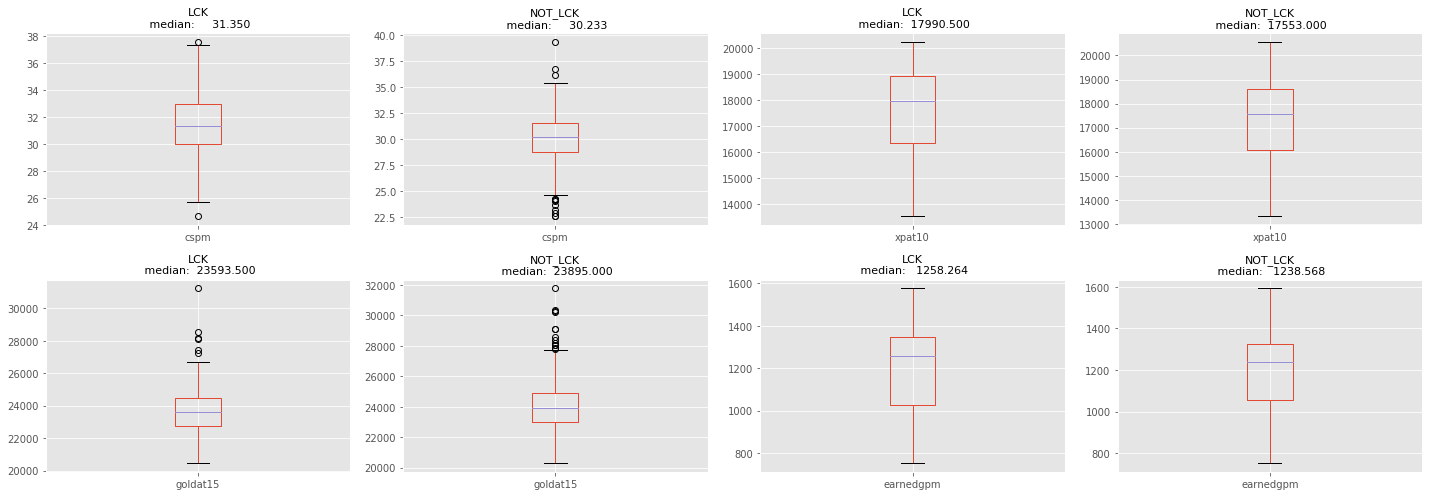


Contributions to PCA component 1:


,gdat15,gdat10,Explained Variance,gspd,earnedgpm,xpdat10,goldat15,oppgoldat15,monsterkillsenemyjungle,oppgoldat10,goldat10,xpat10,cspm,monsterkills,totalgold,oppxpat10,goldspent,monsterkillsownjungle,minionkills,earnedgoldshare_
Dimension 1,0.3672,0.3490,0.3378,0.3313,0.3192,0.3091,0.2992,-0.2965,0.2735,-0.2468,0.2423,0.1258,0.1186,0.1090,0.0974,-0.0956,0.0570,-0.0203,-0.0173,-0.0
Dimension 2,-0.0856,-0.0754,0.2657,-0.0415,0.0225,-0.0612,-0.1017,0.0337,0.1278,0.0113,-0.0936,0.0978,0.1853,0.4084,0.4168,0.1394,0.4226,0.4173,0.4333,0.0
Dimension 3,-0.0112,-0.0056,0.1160,-0.0311,-0.0297,0.0274,0.0676,0.0939,0.1832,0.2659,0.2529,-0.5671,-0.3230,0.1412,0.1299,-0.5763,0.1271,0.0678,0.0058,-0.0
Dimension 4,-0.0157,-0.0268,0.0739,-0.0294,0.0845,0.0041,0.3958,0.4649,0.0069,0.5086,0.4616,0.2111,0.2311,0.0175,-0.0551,0.2043,-0.0535,0.0171,-0.0132,0.0
Dimension 5,-0.0065,0.3684,0.0635,-0.4336,-0.4555,0.3686,0.0094,0.0216,-0.3042,-0.2193,0.2961,0.1705,-0.1023,0.0179,-0.0502,-0.0937,0.0115,0.1886,0.1309,0.0


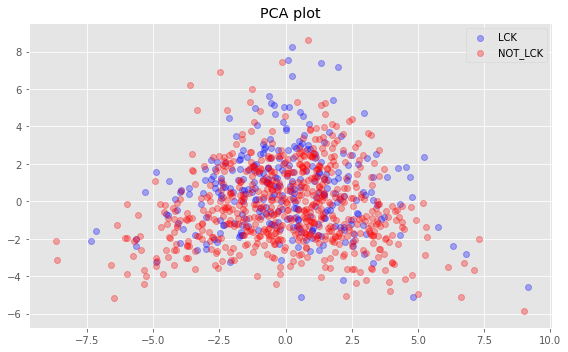


RUNNING ANALYSIS FOR vision



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [2] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is LOGSITIC REGRESSION with an auc of:     0.6085



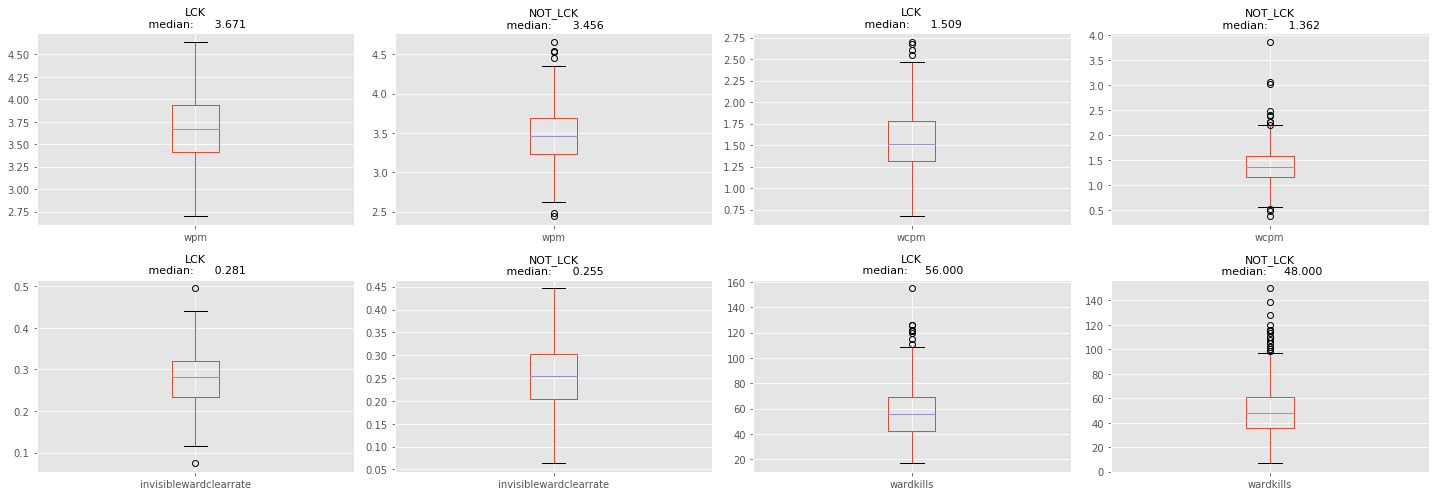


Contributions to PCA component 1:


,Explained Variance,wardkills,visionwards,wards,visionwardbuys,wcpm,wpm,invisiblewardclearrate,visiblewardclearrate,wardshare
Dimension 1,0.6029,0.4106,0.4066,0.4055,0.4015,0.3554,0.3273,0.3136,0.0927,0.0
Dimension 2,0.1600,0.2069,-0.2435,-0.1999,-0.2505,0.4085,-0.3028,0.2767,0.6782,-0.0
Dimension 3,0.0912,0.1461,-0.1526,-0.1404,-0.1306,0.2577,-0.2712,0.5504,-0.6898,-0.0
Dimension 4,0.0612,0.1254,-0.4280,0.1728,-0.4715,0.2872,0.6442,-0.1906,-0.1227,-0.0
Dimension 5,0.0537,0.4821,-0.0189,0.2541,0.0019,0.2164,-0.4869,-0.6240,-0.1714,-0.0


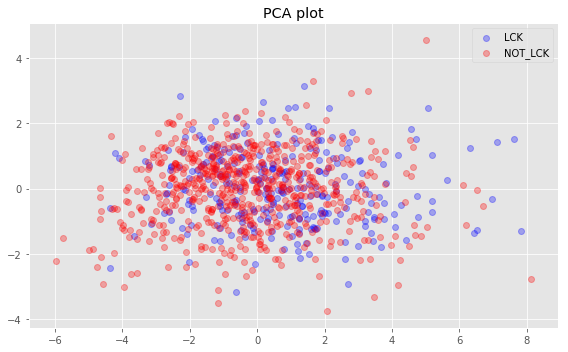


RUNNING ANALYSIS FOR obj_ctr

Best Performing Algorithm is ADABOOST with an auc of:     0.6167



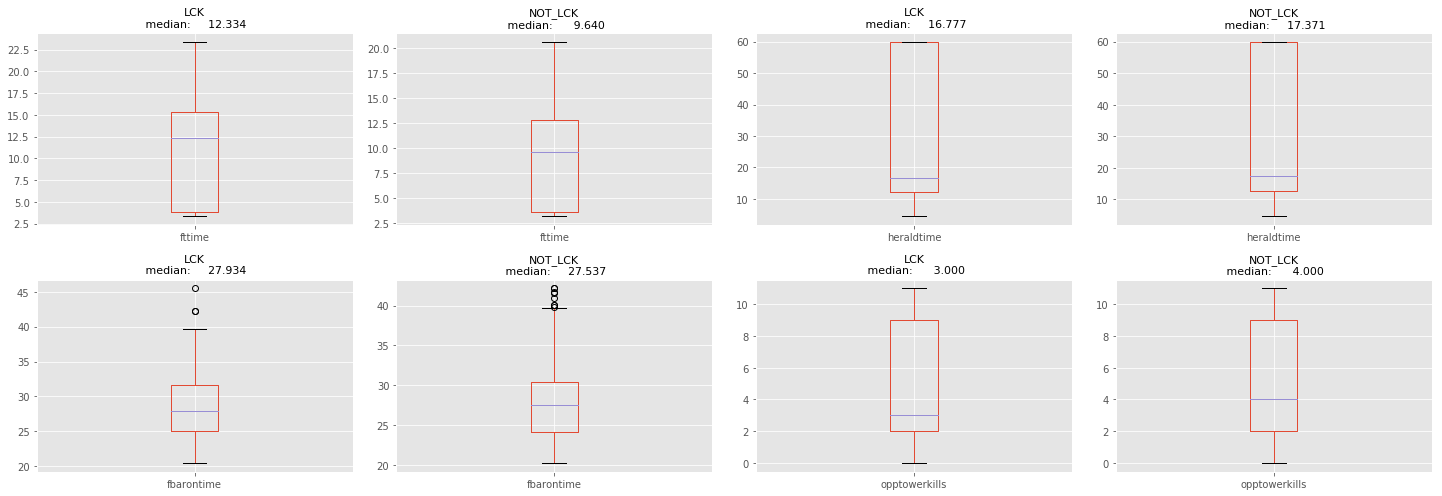


Contributions to PCA component 1:


,opptowerkills,teamtowerkills,Explained Variance,fbaron,oppbaronkills,oppdragkills,firsttothreetowers,teamdragkills,firstmidouter,teambaronkills,ft,herald,fbarontime,heraldtime,fttime
Dimension 1,0.3928,-0.3840,0.3745,-0.3573,0.3307,0.3113,-0.2948,-0.2813,-0.2740,-0.2713,-0.1695,-0.1397,0.0254,0.0244,0.0082
Dimension 2,-0.0469,-0.0080,0.1207,0.0722,-0.0488,-0.0572,-0.0202,0.0450,-0.0191,0.0934,-0.0098,-0.5370,0.2111,0.6601,0.4545
Dimension 3,0.0146,0.1005,0.0887,0.3223,-0.2697,0.1293,-0.4456,0.0260,-0.4080,0.4417,-0.4209,-0.0852,0.0593,-0.0883,-0.1998
Dimension 4,0.1022,0.0681,0.0768,-0.1103,0.1270,0.0821,0.0162,0.4380,0.0136,-0.0314,0.0543,0.0426,0.8444,-0.1094,-0.1642
Dimension 5,-0.0594,0.0019,0.0693,0.1812,-0.1536,0.3816,0.0002,-0.4024,-0.1250,0.1161,0.3247,0.3387,0.2750,-0.1668,0.5289


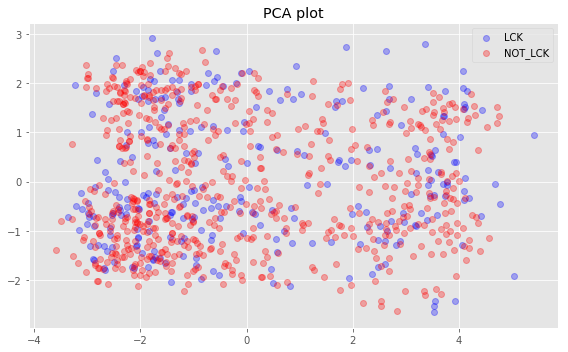


RUNNING ANALYSIS FOR action



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0 1 2 3 4] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is ADABOOST with an auc of:     0.5330



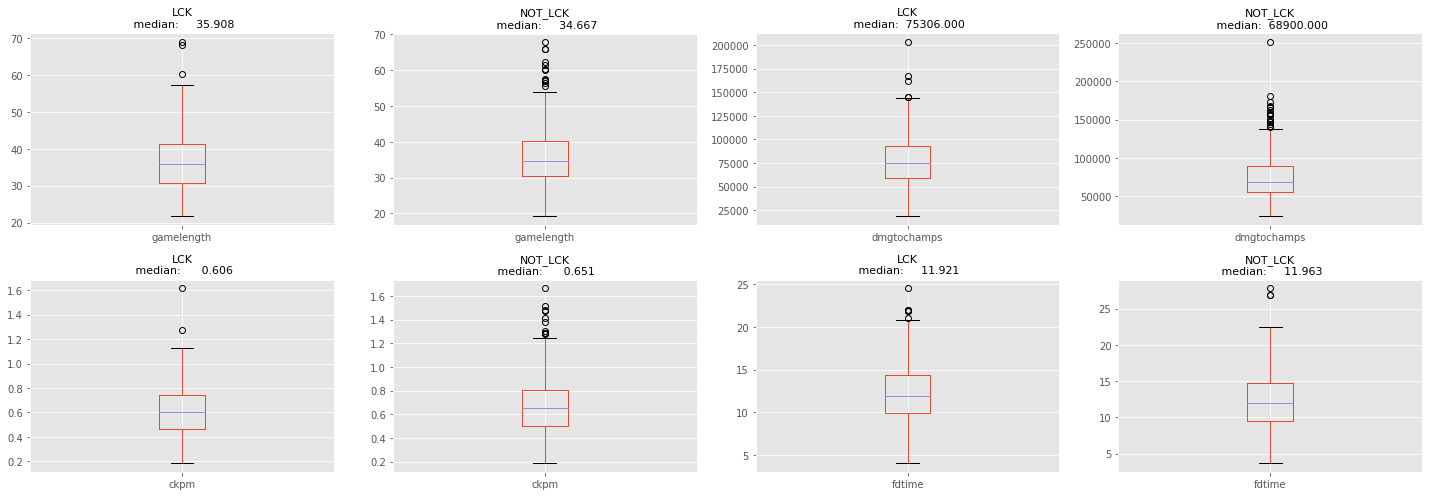


Contributions to PCA component 1:


,k,teamkills,kpm,a,Explained Variance,dmgtochampsperminute,fbvictim,fb,fbassist,ckpm,...,d,fd,fbtime,fdtime,gamelength,dmgshare_,pentas_,quadras_,triples_,doubles_
Dimension 1,0.3957,0.3957,0.3768,0.3730,0.3256,0.2701,-0.2463,0.2463,0.2308,0.2015,...,-0.1453,0.1064,-0.0634,0.0287,0.0002,-0.0,-0.0,-0.0,0.0,-0.0
Dimension 2,0.1229,0.1229,0.0154,0.1120,0.2353,0.2593,0.1991,-0.1991,-0.1887,0.3093,...,0.4259,-0.0966,-0.1236,0.0985,0.2206,-0.0,0.0,-0.0,0.0,-0.0
Dimension 3,-0.1287,-0.1287,-0.1555,-0.1613,0.1213,-0.0711,-0.4850,0.4850,0.4835,0.0550,...,0.2508,-0.0909,-0.0367,0.0658,0.0617,0.0,-0.0,0.0,-0.0,-0.0
Dimension 4,-0.0350,-0.0350,-0.2611,0.0449,0.1137,0.1873,-0.0323,0.0323,0.0407,-0.4256,...,-0.0448,0.0054,0.2831,0.0435,0.5857,0.0,-0.0,-0.0,0.0,-0.0
Dimension 5,-0.0810,-0.0810,-0.0460,-0.0940,0.0604,0.1061,0.0042,-0.0042,-0.0371,-0.0799,...,-0.0678,0.3092,-0.3646,0.8437,-0.0605,-0.0,-0.0,0.0,-0.0,0.0


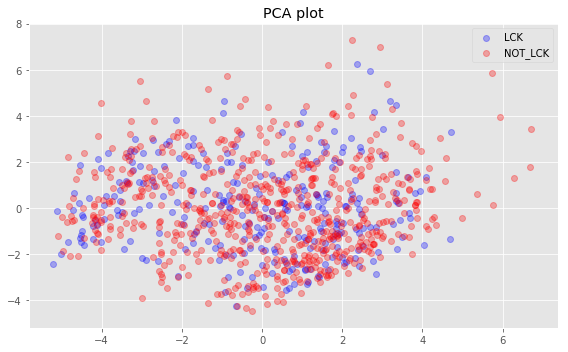


RUNNING ANALYSIS FOR team_comp



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  0 209] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is RANDOM FOREST with an auc of:     0.6848



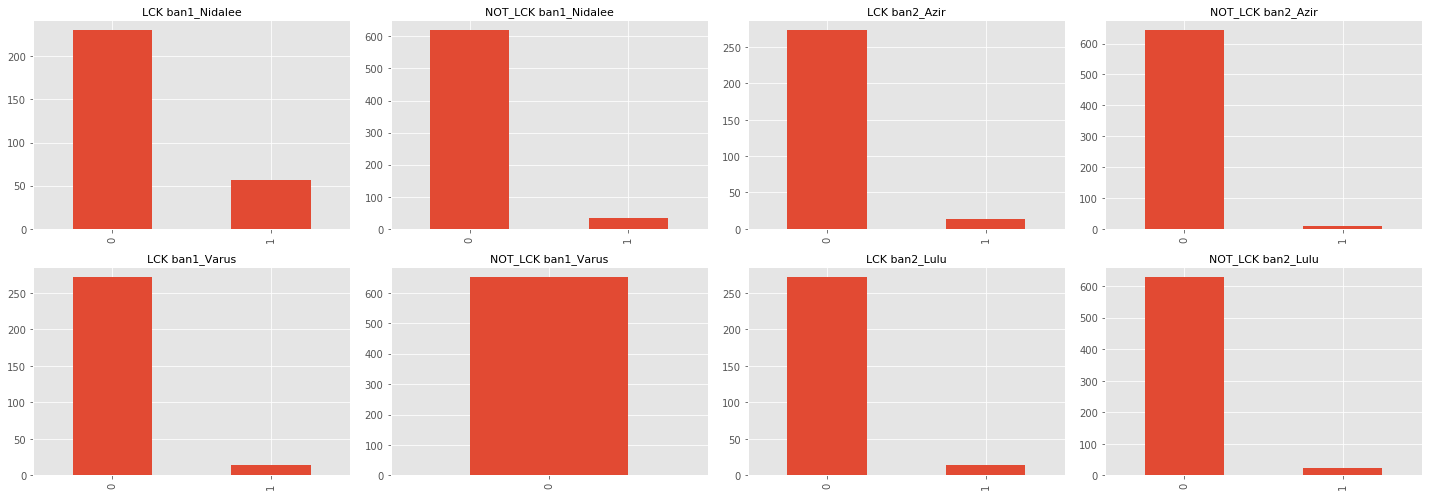


Contributions to PCA component 1:


,ban1_Twitch,ban3_Kalista,ban2_Vladimir,ban2_Illaoi,ban2_Lulu,ban1_Lulu,ban3_Malzahar,ban1_Jhin,ban2_Kassadin,ban3_Corki,...,ban2_Ryze,ban2_Ashe,ban3_Jax,ban1_Maokai,ban3_Janna,ban1_Trundle,ban1_Syndra,ban1_Jax,champion_,position_Team
Dimension 1,0.1972,-0.1835,0.1749,0.1659,-0.1595,-0.1482,0.1456,0.1455,0.1436,-0.1404,...,-0.0033,-0.0025,0.0024,-0.0022,-0.0017,0.0013,-0.0008,0.0007,-0.0,0.0
Dimension 2,-0.0788,-0.0005,-0.0577,-0.0267,0.0316,-0.0218,-0.0672,-0.0500,0.4851,0.0444,...,-0.0088,0.0222,-0.0008,-0.0153,-0.0114,-0.0222,-0.0360,-0.0007,-0.0,-0.0
Dimension 3,-0.0742,-0.0522,-0.0483,-0.0630,-0.0202,-0.0317,-0.0290,-0.0359,-0.0473,0.0079,...,0.0917,-0.0151,-0.0018,0.0028,0.0317,-0.0137,-0.0114,0.0179,0.0,-0.0
Dimension 4,0.4814,0.0629,0.0029,0.4036,0.0081,0.0325,0.0439,-0.0201,-0.0160,0.0268,...,-0.0257,0.0241,-0.0084,0.0308,-0.0016,0.0601,0.0533,-0.0066,-0.0,-0.0
Dimension 5,0.0771,0.0629,-0.0214,0.0545,0.0856,0.0603,0.0214,-0.0008,0.1339,-0.0245,...,-0.1913,-0.0292,-0.0264,-0.0770,-0.0319,-0.0173,-0.0373,-0.0432,0.0,-0.0


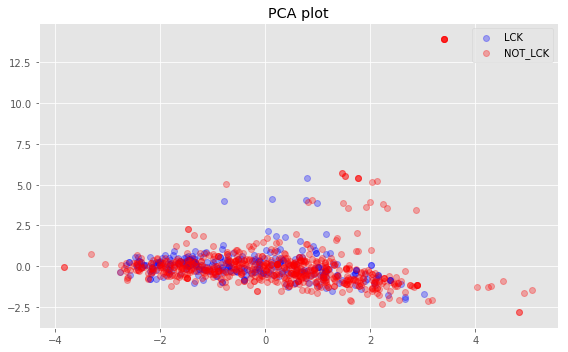

YEAR: 2017

RUNNING ANALYSIS FOR gold_gen



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is RANDOM FOREST with an auc of:     0.5645



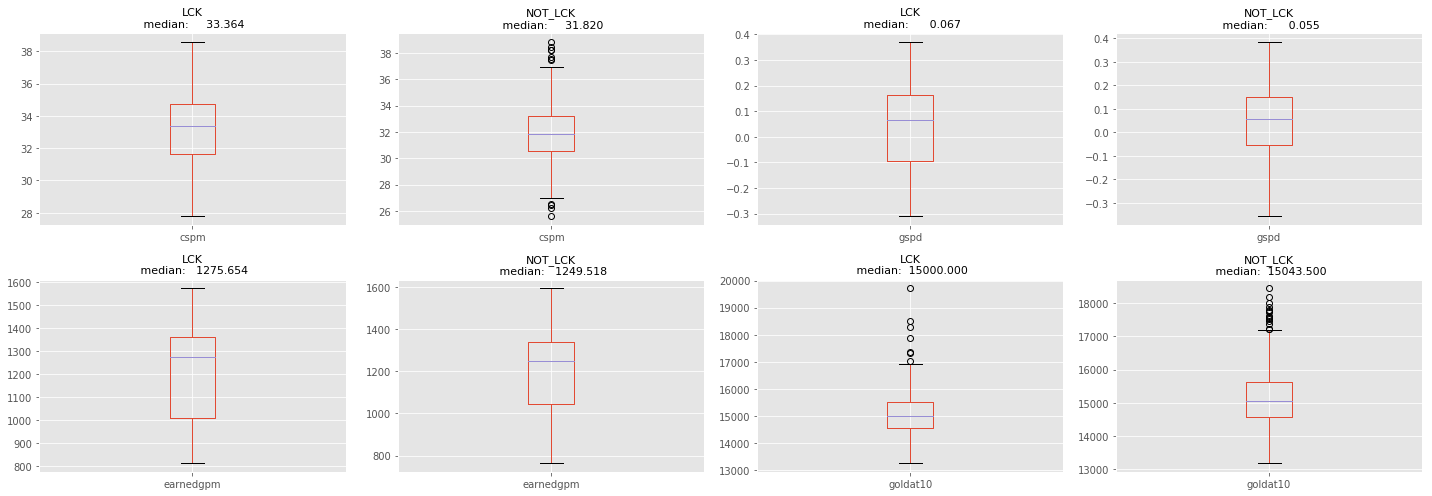


Contributions to PCA component 1:


,Explained Variance,gdat15,gdat10,xpdat10,goldat15,csdat15,oppgoldat15,gspd,goldat10,csdat10,...,csat10,csat15,cspm,monsterkillsenemyjungle,monsterkills,monsterkillsownjungle,totalgold,minionkills,goldspent,earnedgoldshare_
Dimension 1,0.3210,0.3167,0.3136,0.2961,0.2656,0.2654,-0.2622,0.2544,0.2540,0.2512,...,0.1532,0.1403,0.1127,0.1041,0.0510,-0.0422,0.0414,-0.0349,0.0122,0.0
Dimension 2,0.2062,-0.0477,-0.0396,-0.0197,-0.0693,0.0020,0.0074,0.0110,-0.0384,-0.0021,...,0.1256,0.1654,0.1700,0.2590,0.4053,0.3927,0.3874,0.4021,0.3884,-0.0
Dimension 3,0.1271,0.0086,0.0115,0.0088,0.0325,-0.0274,0.0205,0.0092,0.0298,-0.0133,...,-0.4019,-0.3971,-0.2476,0.0735,0.1021,0.1189,0.2157,0.1320,0.2255,0.0
Dimension 4,0.0826,-0.2080,-0.1119,0.0685,-0.2024,0.3767,0.1415,-0.3191,-0.1094,0.4619,...,0.2486,0.1957,0.0107,-0.0212,0.0446,0.0954,-0.0979,0.0533,-0.0486,-0.0
Dimension 5,0.0506,-0.0173,-0.2762,-0.2577,0.2013,0.2353,0.2505,0.3046,0.0241,0.0720,...,0.0051,0.0848,0.2299,0.2191,0.0301,-0.1322,-0.0101,-0.1230,-0.0597,-0.0


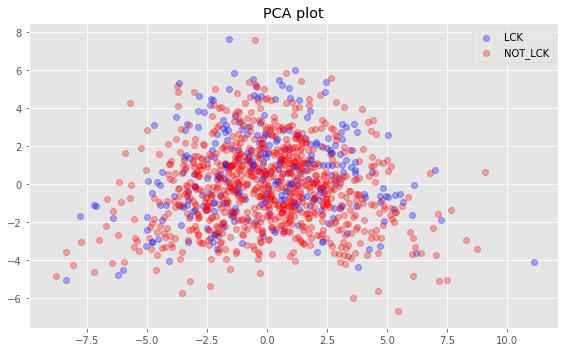


RUNNING ANALYSIS FOR vision



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [2] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is RANDOM FOREST with an auc of:     0.5606



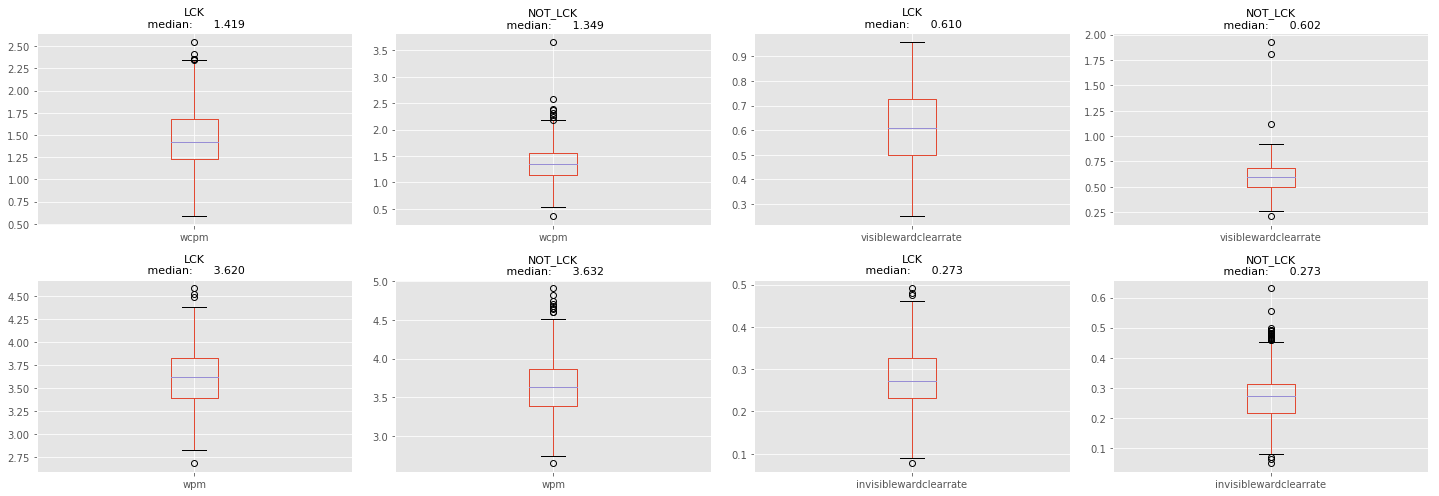


Contributions to PCA component 1:


,Explained Variance,wardkills,wards,visionwardbuys,visionwards,wcpm,invisiblewardclearrate,wpm,visiblewardclearrate,wardshare
Dimension 1,0.5186,0.4372,0.4300,0.4213,0.3630,0.3545,0.3172,0.2963,0.0268,0.0
Dimension 2,0.1947,0.2625,-0.1718,-0.1498,-0.3823,0.4820,0.1530,-0.2552,0.6419,-0.0
Dimension 3,0.1405,-0.0739,0.2329,0.2583,-0.2189,-0.1629,-0.5992,0.4656,0.4726,0.0
Dimension 4,0.0634,0.2974,0.2955,0.2097,0.1811,-0.1976,-0.3811,-0.7483,0.0560,-0.0
Dimension 5,0.0384,-0.3578,-0.2865,0.2054,0.5736,-0.2349,0.2437,-0.0802,0.5456,0.0


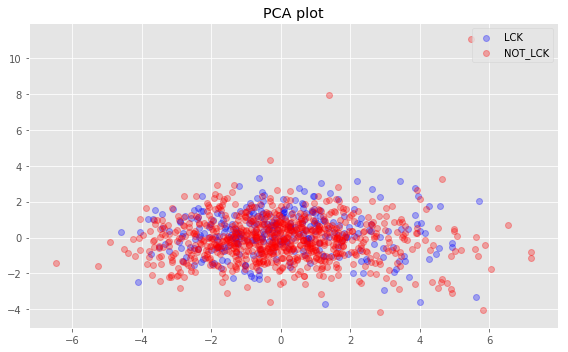


RUNNING ANALYSIS FOR obj_ctr

Best Performing Algorithm is RANDOM FOREST with an auc of:     0.5443



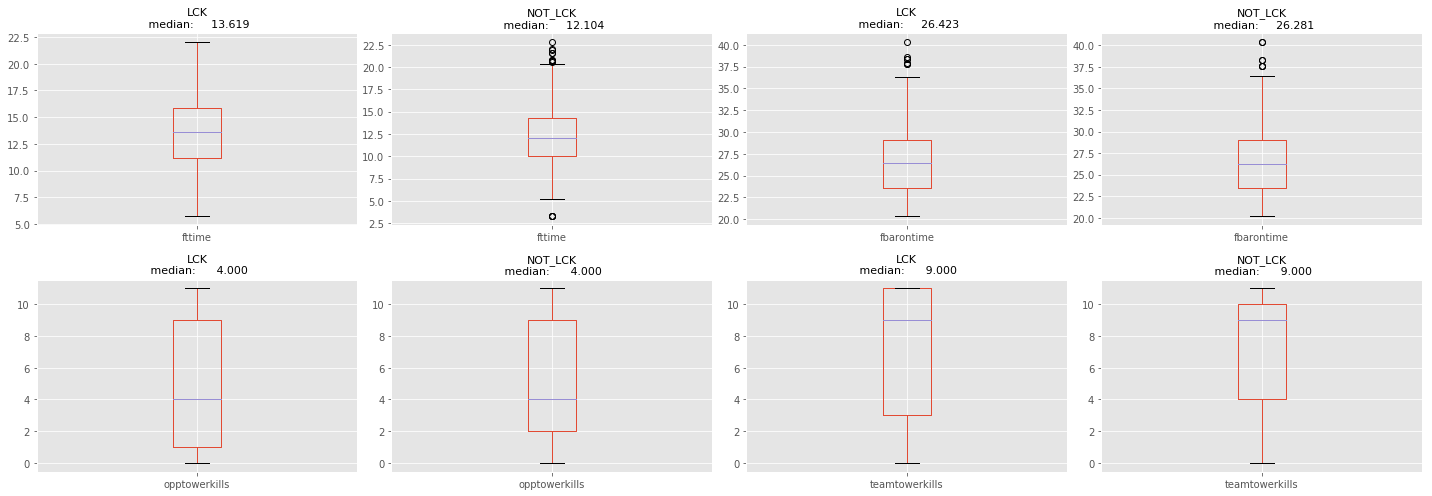


Contributions to PCA component 1:


,Explained Variance,opptowerkills,teamtowerkills,oppdragkills,oppelementals,elementals,teamdragkills,firsttothreetowers,fbaron,oppbaronkills,...,airdrakes,earthdrakes,herald,firedrakes,waterdrakes,oppelders,elders,heraldtime,fbarontime,fttime
Dimension 1,0.3256,0.3182,-0.3117,0.3087,0.3082,-0.3037,-0.2890,-0.2694,-0.2648,0.2473,...,-0.1366,-0.1318,-0.1295,-0.1264,-0.1120,0.1093,-0.0505,0.0350,0.0171,0.0014
Dimension 2,0.0934,0.1508,0.0657,0.0944,0.0215,0.2425,0.3535,-0.1084,-0.0579,0.1942,...,0.1581,0.0349,-0.2951,0.0762,0.1349,0.2651,0.4342,0.2895,0.3890,0.1699
Dimension 3,0.0704,-0.2189,0.2180,0.2484,0.2436,-0.2595,-0.2441,-0.0327,0.4203,-0.3777,...,-0.1558,-0.1357,-0.1809,0.0118,-0.1522,0.1018,-0.0240,0.2072,0.1289,0.1297
Dimension 4,0.0622,0.0738,0.1492,0.2707,0.2088,-0.0325,0.0633,0.0237,0.0678,0.1801,...,-0.0474,0.0147,0.4553,0.0077,-0.0287,0.2914,0.2876,-0.4638,0.0049,-0.3616
Dimension 5,0.0575,0.0017,0.0183,0.1562,0.0347,-0.0353,-0.1040,0.3786,-0.1068,0.1655,...,-0.0534,0.0430,0.0711,-0.0287,-0.0193,0.4412,-0.2237,0.2118,0.2295,0.1921


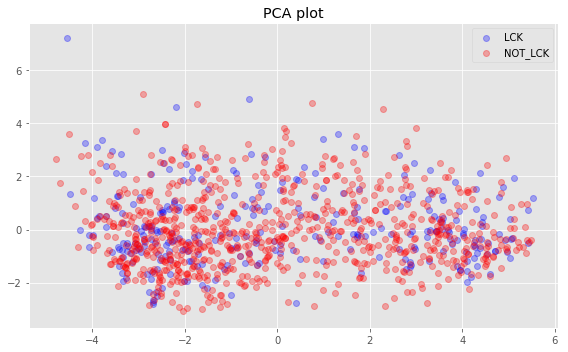


RUNNING ANALYSIS FOR action



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0 1 2 3 4] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is RANDOM FOREST with an auc of:     0.5596



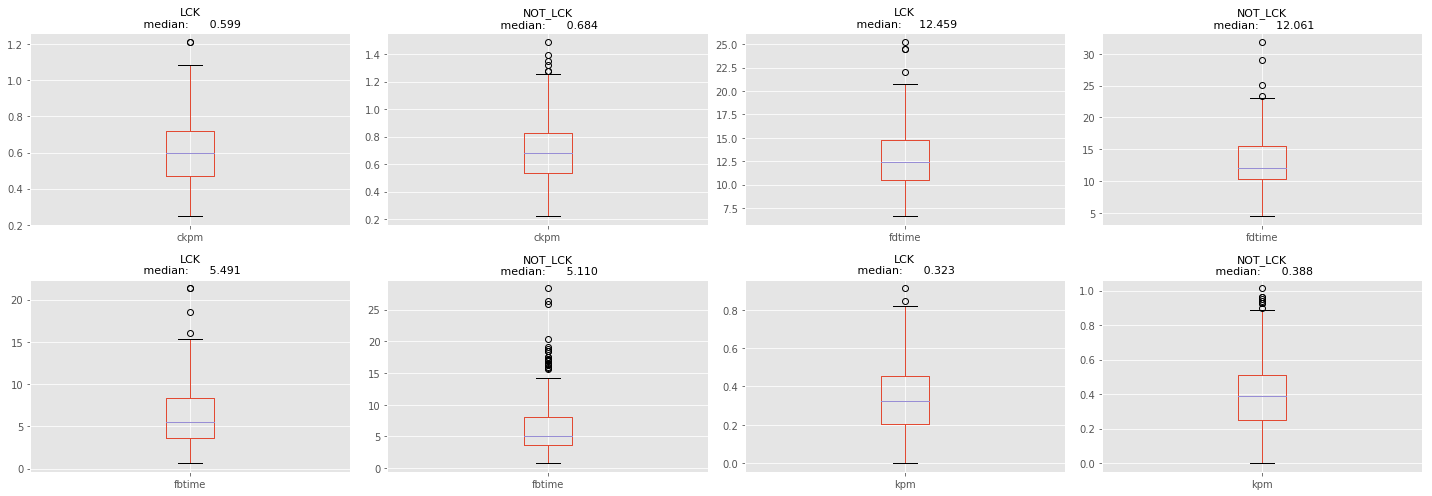


Contributions to PCA component 1:


,k,teamkills,a,kpm,Explained Variance,dmgtochampsperminute,dmgtochamps,okpm,fbvictim,fb,...,d,fd,gamelength,fbtime,fdtime,dmgshare_,pentas_,quadras_,triples_,doubles_
Dimension 1,0.4091,0.4091,0.3859,0.3827,0.3110,0.2999,0.2113,-0.1997,-0.1875,0.1875,...,-0.1471,0.1088,0.0460,-0.0442,-0.0195,-0.0,-0.0,-0.0,-0.0,-0.0
Dimension 2,0.1159,0.1159,0.1129,-0.0211,0.2238,0.2196,0.2998,0.3663,0.2157,-0.2157,...,0.4356,-0.1213,0.2551,-0.1058,-0.0056,-0.0,-0.0,-0.0,-0.0,-0.0
Dimension 3,-0.0942,-0.0942,-0.1293,-0.1393,0.1389,-0.0151,0.0560,0.2205,-0.5083,0.5083,...,0.2427,-0.0359,0.1004,0.0074,-0.0377,-0.0,-0.0,-0.0,-0.0,-0.0
Dimension 4,-0.0474,-0.0474,0.0309,-0.2762,0.1150,0.1844,0.4350,-0.2604,0.0061,-0.0061,...,-0.0575,-0.0229,0.5474,0.2819,0.1155,-0.0,-0.0,0.0,0.0,-0.0
Dimension 5,-0.0044,-0.0044,-0.0200,0.0572,0.0592,0.0502,-0.0455,0.0905,-0.0122,0.0122,...,0.0399,0.1985,-0.1249,0.3024,0.9038,0.0,0.0,0.0,0.0,-0.0


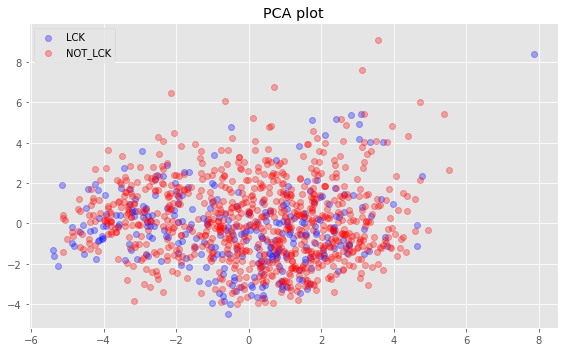


RUNNING ANALYSIS FOR team_comp



C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  0 396] are constant.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Best Performing Algorithm is LOGSITIC REGRESSION with an auc of:     0.6586



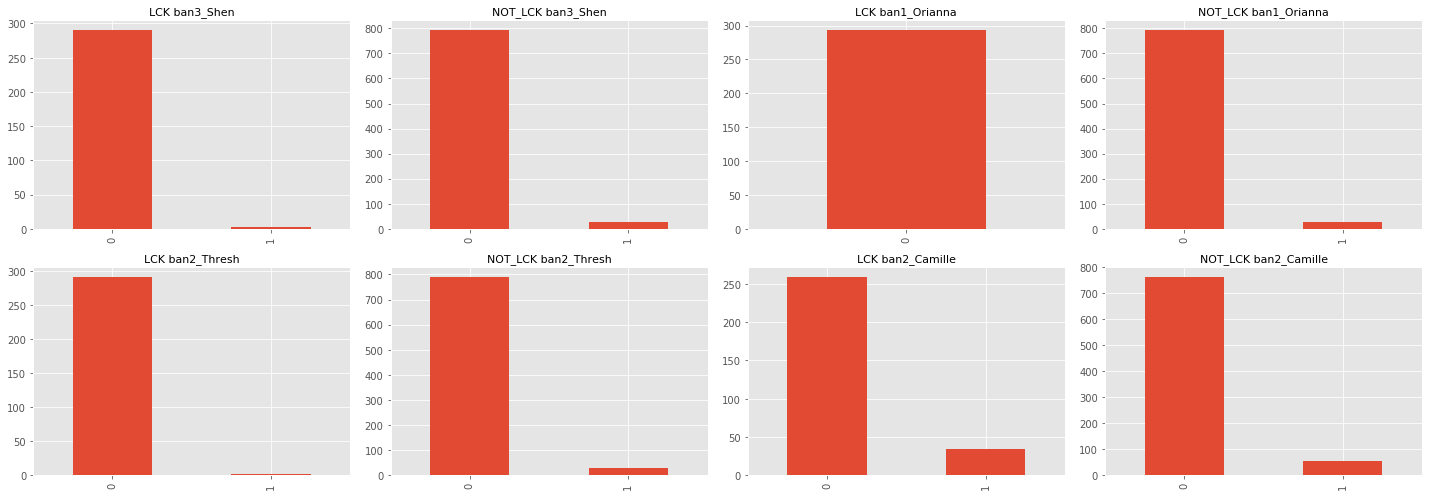


Contributions to PCA component 1:


,ban1_Zac,ban2_Camille,ban1_Camille,ban1_Malzahar,ban2_Caitlyn,ban3_LeBlanc,ban1_Rengar,ban3_Camille,ban3_Kalista,ban2_Galio,...,ban3_Blitzcrank,ban4_Gragas,ban2_Fiora,ban5_Fizz,ban4_Kled,ban5_Nidalee,ban1_Twitch,ban4_Kennen,champion_,position_Team
Dimension 1,0.2075,-0.1811,-0.1433,-0.1425,0.1423,-0.1369,-0.1368,-0.1343,0.1314,0.1261,...,0.0018,-0.0016,-0.0016,-0.0012,0.0007,0.0004,0.0004,0.0002,0.0,0.0
Dimension 2,0.0974,0.0256,-0.0120,-0.0262,0.0743,-0.0079,-0.0042,-0.1124,0.0182,0.0062,...,0.1959,-0.0145,0.0255,0.0171,0.0250,0.0159,0.0243,0.0071,0.0,0.0
Dimension 3,0.0035,-0.1178,-0.0415,-0.0044,0.0157,0.0177,-0.0155,0.0882,-0.0074,-0.0105,...,0.4122,-0.0225,0.0442,0.0509,0.0175,-0.0104,0.0500,0.0058,0.0,-0.0
Dimension 4,-0.1914,0.1303,0.0189,0.0181,-0.1296,0.0010,0.0498,-0.1058,-0.0567,-0.0282,...,0.2654,0.0044,0.0051,-0.0129,-0.0199,-0.0085,0.0299,-0.0089,-0.0,-0.0
Dimension 5,-0.0186,-0.1119,0.0292,-0.0127,-0.0012,0.0224,-0.0104,0.0155,0.0493,0.0085,...,-0.0757,-0.0059,-0.0075,-0.0393,-0.0078,-0.0246,0.0234,-0.0429,0.0,-0.0


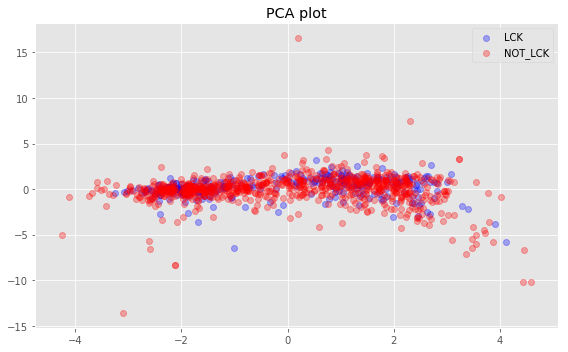

YEAR: 2018


ValueError: labels ['compare'] not contained in axis

In [353]:
import analytics_utils
from analytics_utils import *
import parsing_utils
from parsing_utils import *
import importlib
import sys
importlib.reload(analytics_utils)
importlib.reload(parsing_utils)
#focus = "team"
#season = "playoffs"
#anti_joins = ["na-cs","eu-cs"]
#aliases = ["na","lck","eu","lms"]
#leagues = ["NALCS","LCK","EULCS","LMS"]
#aliases = ["lck","lck"]
#leagues = ["LCK","LCK"]
role = ""
#aliases.remove("eu")
#aliases.remove("na")
#leagues.remove("EULCS")
#leagues.remove("NALCS")
region = "LCK"
def get_features(col_feat, region, year):
    focus,join,anti_join,aliases,leagues = col_feat[0],col_feat[1],col_feat[2],col_feat[3], col_feat[4]
    db_dir = ".//databases"
    all_player_stats, all_teams = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)
    role = ""
    others = []
    for ii in all_player_stats.keys():
        if ii != region:
            others.append(all_player_stats[ii])
    others = pd.concat(others,axis=0)
    others.loc[:,"compare"] = "NOT_"+region
    reg = all_player_stats[region]
    reg.loc[:,"compare"] = region
    to_run = {region:reg,"ALL":others}
    return to_run, all_teams

def one_vs_all(all_player_stats, region):
    others = []
    teams = {}
    for ii in all_player_stats.keys():
        if ii != region:
            others.append(all_player_stats[ii])
    others = pd.concat(others,axis=0)
    others.loc[:,"compare"] = "NOT_"+region
    reg = all_player_stats[region]
    reg.loc[:,"compare"] = region
    to_run = {region:reg,"ALL":others}
    teams[region] = reg["team"].unique()
    teams["NOT_"+region] = others["team"].unique()
    return to_run, teams

def run_analysis(features, to_run, role, pca=False, analysis=True):
    for ii,jj in features:
        var = ii[:]
        var.append("compare")    
        matches,data, y, colnames = get_subset_data(to_run ,var, role,"compare")
        if analysis:
            print("\nRUNNING ANALYSIS FOR {}\n".format(jj))
            table = run_subset_analysis(data,y,colnames,matches)
            if pca:
                unsupervised_analysis(data,y,colnames)
            else:
                display(table)
    return matches, data, y, colnames

#features = [(action,"action")]
#features_vs = [(early_game,"early game")]
features = list(zip([gold_gen,vision,obj_ctr,action,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"]))
#features_vs = list(zip([gold_gen,vision,obj_ctr_vs,action_vs,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"]))
#year_teams = {}
#features = [(obj_ctr,"obj_ctr")]
#features_vs = [(obj_ctr_vs,"obj_ctr")]
years = ["2016", "2017","2018"]
#years = ["2017"]
#roles = ["Top","Jungle","Middle","ADC", "Support"]
for ii in years:
    role = ""
    #print("ROLE: {}".format(role))
    year = ii
    joins = [year,focus,season]
    features = zip([gold_gen,vision,obj_ctr,action,team_comp],["gold_gen","vision","obj_ctr","action","team_comp"])
    print("YEAR: {}".format(year))
    all_matches = get_matches(year, True)
    #to_run = all_matches
    to_run, teams= one_vs_all(all_matches,region)
    matches, data, y, colnames = run_analysis(features, to_run, role, True, True)
    all_matches[year] = [matches, y]
    #year_teams[year] = teams
    vs_matches = None
    #vs_matches = vs_matches_for_year_team(region,year, teams)
    if vs_matches:
        #run_analysis(features_vs, vs_matches, role)
        print("")
        

YEAR: 2016


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


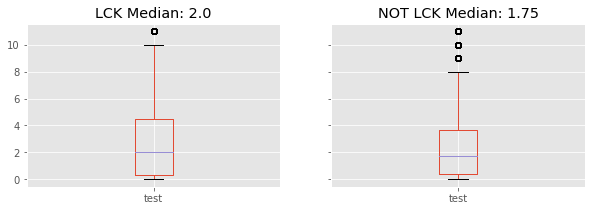

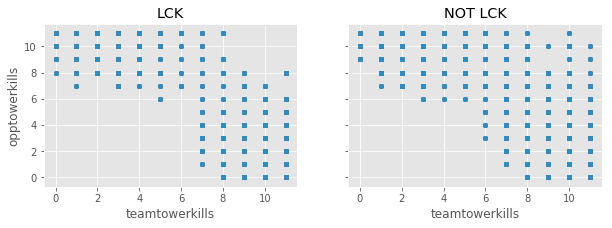

YEAR: 2017


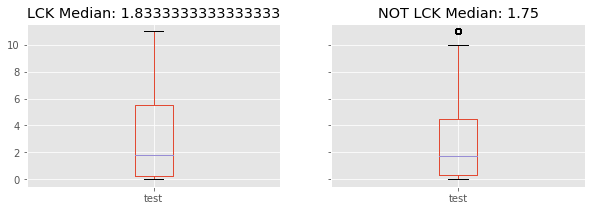

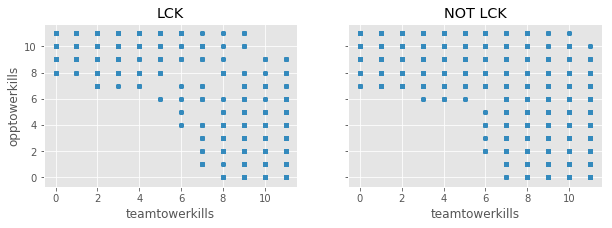

YEAR: 2018


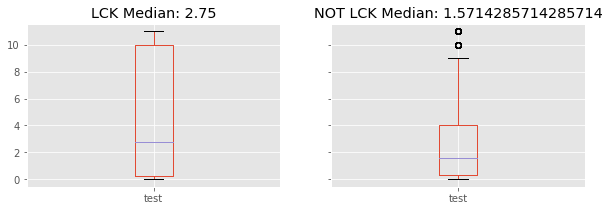

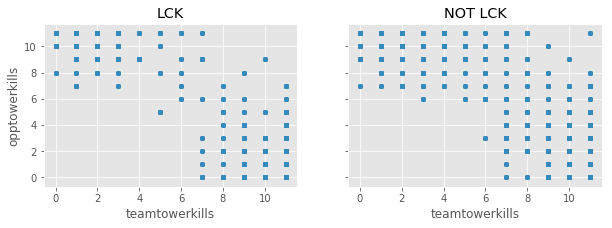

In [258]:
to_name = "test"
var1 = "teamtowerkills"
var2 = "opptowerkills"
var3= "teamtowerkills"
for ii in years:
    print("YEAR: {}".format(ii))
    matches = all_matches[ii][0]
    y = all_matches[ii][1]
    lck = matches[y=="LCK"]
    others = matches[y=="NOT_LCK"]
    lck[to_name] = lck[var1]/lck[var2]#/lck[var3]
    others[to_name] = others[var1]/others[var2]#/others[var3]
    fig,axes = get_fig_axes(1,2,10,3,sharey=True)
    lck.boxplot(to_name,ax=axes[0])
    axes[0].set_title("LCK Median: {}".format(lck[to_name].median()))
    others.boxplot(to_name,ax=axes[1])
    axes[1].set_title("NOT LCK Median: {}".format(others[to_name].median()))
    plt.show()

    fig,axes = get_fig_axes(1,2,10,3,sharey=True)
    lck.plot.scatter(x=var1,y=var2,ax=axes[0])
    axes[0].set_title("LCK")
    others.plot.scatter(x=var1,y=var2,ax=axes[1])
    axes[1].set_title("NOT LCK")
    plt.show()

## Latent variables  
### Objective Control
teamtowerkills - opptowerkills  
fttime  
